In [23]:
import mne
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
def cleanEvents(events):
    cleanedEvents = []
    ignoreEvents = [100, 200, 201]
    for event in events[0]:
        if event[2] in ignoreEvents:
            continue
        else:
            cleanedEvents.append(event)
    cleanedEvents = np.array(cleanedEvents)
    return cleanedEvents

def perceptionAndImaginationEvents(events): 
    cleanedEvents = cleanEvents(events)
    perceptionKeys = []
    imaginationKeys = []
    for item, key in events[1].items():
        if 'Perception' in item:
            perceptionKeys.append(key)
        if 'Imagination' in item:
            imaginationKeys.append(key)

    for index in range(cleanedEvents.shape[0]):
        key = cleanedEvents[index][2]
        if key in perceptionKeys:
            cleanedEvents[index][2] = 1
        elif key in imaginationKeys:
            cleanedEvents[index][2] = 2

    return cleanedEvents
    


In [3]:
def getPerceptionImaginationDataFromSubject(filepath):
    print(f'Loading MNE Data {filepath}')
    data = mne.io.read_raw_fif(filepath, preload=True, verbose=False)
    events = mne.events_from_annotations(data)
    cleanedEvents = perceptionAndImaginationEvents(events)
    newEventId = {'Perception':1, 'Imagination':2}
    epochs = mne.Epochs(data.copy(), cleanedEvents, event_id=newEventId, tmin=-0.2, tmax=1.0, preload=True)
    perception = epochs['Perception'].get_data()
    imagination = epochs['Imagination'].get_data()
    
    return perception, imagination

In [4]:
def createXAndY(filepath, start=230):
    perception, imagination =  getPerceptionImaginationDataFromSubject(filepath)
    perception = perception[:,:,start:]
    imagination = imagination[:,:,start:]
    imagLables= np.array([0 for i in range(imagination.shape[0])])
    perceptionLabels = np.array([1 for i in range(imagination.shape[0])])
    labels = np.concatenate((imagLables, perceptionLabels), axis=0)
    X = np.concatenate((imagination, perception), axis=0)
    X_flat = X.reshape(X.shape[0], -1)
    return X_flat, labels

In [20]:
def trainModel(filepath):
    X, y = createXAndY(filepath)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

    print(X_train.shape, X_test.shape)
    print('Applying PCA for Dimentionality Reduction')
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print('Training model')
    model = RandomForestClassifier(max_depth=30,
                                min_samples_split=10,
                                max_features='log2',
                                oob_score=True
                            )
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    report = classification_report(y_test, y_pred, target_names=['Imagination', 'perception'], output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    return report, cm
   

    

In [24]:
filepaths = ['C:\ImaginationPerceptionDataset\DataSet\perceptionImaginationEEG\preprocessed\sub-03\ses-03\eeg\sub3_sess3_50_ica_eeg.fif']
subjectIds = []
sessionIds = []
average_precision = []
avergare_recall = []
average_f1_score = []

for filepath in filepaths:
    subjectId = filepath.split('\\')[-4]
    sessionId = filepath.split('\\')[-3]
    subjectIds.append(subjectId)
    sessionIds.append(sessionId)
    report, cm = trainModel(filepath)

    average_precision.append(report['weighted avg']['precision'])
    avergare_recall.append(report['weighted avg']['recall'])
    average_f1_score.append(report['weighted avg']['f1-score'])


data = {'SubjectID': subjectIds,
    'SessionID':sessionIds,
    'Precision':average_precision,
    'Recall':avergare_recall,
    'f1-score': average_f1_score
    }
data = pd.DataFrame(data)

Loading MNE Data C:\ImaginationPerceptionDataset\DataSet\perceptionImaginationEEG\preprocessed\sub-03\ses-03\eeg\sub3_sess3_50_ica_eeg.fif
Used Annotations descriptions: ['0, Imagination_a_flower_high_10###my_stream_name', '0, Imagination_a_flower_high_11###my_stream_name', '0, Imagination_a_flower_high_17###my_stream_name', '0, Imagination_a_flower_high_23###my_stream_name', '0, Imagination_a_flower_high_4###my_stream_name', '0, Imagination_a_flower_high_5###my_stream_name', '0, Imagination_a_flower_low_10###my_stream_name', '0, Imagination_a_flower_low_13###my_stream_name', '0, Imagination_a_flower_low_17###my_stream_name', '0, Imagination_a_flower_low_23###my_stream_name', '0, Imagination_a_flower_low_25###my_stream_name', '0, Imagination_a_flower_low_5###my_stream_name', '0, Imagination_a_flower_normal_10###my_stream_name', '0, Imagination_a_flower_normal_11###my_stream_name', '0, Imagination_a_flower_normal_12###my_stream_name', '0, Imagination_a_flower_normal_16###my_stream_name'

C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_4148\3163168001.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  perception = epochs['Perception'].get_data()
C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_4148\3163168001.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  imagination = epochs['Imagination'].get_data()


(720, 124000) (180, 124000)
Training model


ValueError: Invalid file path or buffer object type: <class 'dict'>

In [25]:
data = pd.

{'SubjectID': ['sub-03'],
 'SessionID': ['ses-03'],
 'Precision': [0.6091789903110658],
 'Recall': [0.6],
 'f1-score': [0.5970238095238095]}

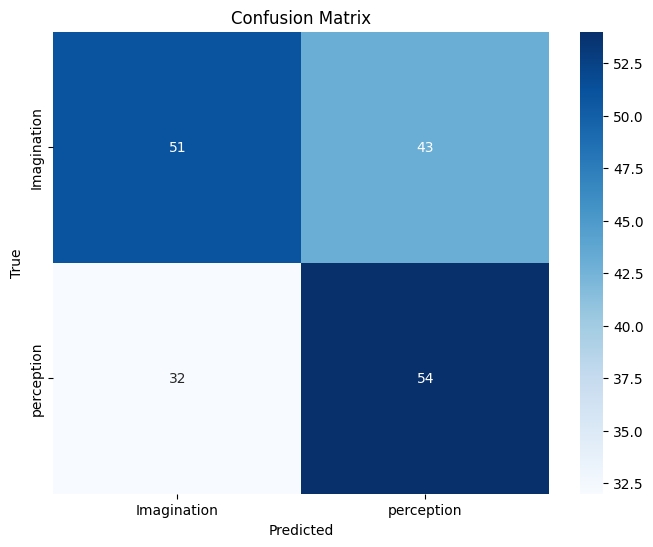

              precision    recall  f1-score   support

 Imagination       0.61      0.54      0.58        94
  perception       0.56      0.63      0.59        86

    accuracy                           0.58       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.59      0.58      0.58       180



In [19]:

import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)
y_pred = rf.predict(X_test_pca)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Imagination', 'perception'], yticklabels=['Imagination', 'perception'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Imagination', 'perception']))

In [52]:
import pandas as pd
model = []
imag_prec = []
imag_recall = []
imag_f1 = []
percep_prec = []
percep_recall = []
percep_f1 = []
weighted_avg = []
m_depth = []
m_samples= []
m_features = []
for max_depth in range(10, 40, 10):
    for min_samples in range(5, 20, 5):
        for max_features in ['sqrt', 'log2']:
            print(f'{max_depth}_{min_samples}_{max_features}')
            rf = RandomForestClassifier(n_estimators=1000,
                                    max_depth=max_depth, 
                                    min_samples_split=min_samples, 
                                    max_features=max_features,
                                    oob_score=True,
                                    warm_start=True,
                                    n_jobs=8)
            rf.fit(X_train_pca, y_train)
            y_pred = rf.predict(X_test_pca)

            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Imagination', 'perception'], yticklabels=['Imagination', 'perception'])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.savefig(f'{max_depth}_{min_samples}_{max_features}.png')
            plt.clf()
            
            report = classification_report(y_test, y_pred, target_names=['Imagination', 'perception'], output_dict=True)
            imag_prec.append(report['Imagination']['precision'])
            imag_recall.append(report['Imagination']['recall'])
            imag_f1.append(report['Imagination']['f1-score'])
            percep_prec.append(report['perception']['precision'])
            percep_recall.append(report['perception']['recall'])
            percep_f1.append(report['perception']['f1-score'])
            model.append(f'{max_depth}_{min_samples}_{max_features}')
            weighted_avg.append(report['weighted avg']['f1-score'])
            m_depth.append(max_depth)
            m_samples.append(min_samples)
            m_features.append(max_features)
data = {'Model_MaxDepth_MinSamplesSplit_MaxFeatures':model,
    'MaxDepth':m_depth,
    'MinSamples':m_samples,
    'MaxFeatures':m_features,
    'Imagination_precision':imag_prec,
    'Imagination_recall':imag_recall,
    'Imagination_f1-score':imag_f1,
    'Perception_precision':percep_prec,
    'Perception_recall':percep_recall,
    'Perception_f1-score': percep_f1,
    'Weighted_f1-score':weighted_avg
}
data =pd.DataFrame(data)

10_5_sqrt
10_5_log2
10_10_sqrt
10_10_log2
10_15_sqrt
10_15_log2
20_5_sqrt
20_5_log2
20_10_sqrt
20_10_log2
20_15_sqrt
20_15_log2
30_5_sqrt
30_5_log2
30_10_sqrt
30_10_log2
30_15_sqrt
30_15_log2


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [53]:
data.to_csv('RandomForestMetrics.csv')

In [45]:
report['weighted avg']

{'precision': 0.6716442674630828,
 'recall': 0.6666666666666666,
 'f1-score': 0.6661725955204216,
 'support': 180.0}